# VR用カスタム学習ツール
author: M. AKaishi

### 初期設定

In [1]:
# APIキーの設定
# この部分はインスタンス毎に書き換えて下さい
api_key = 'xxxx'

# テスト用tarファイルの指定
tar_name = 'cifar-50000.gz'

# 解析元データのトップディレクトリ名
base_dir = 'Images'

# 学習用データ一時保存先
train_dir = 'Train'

# API呼出しZIPファイルの保存先
zip_dir = 'ZIP'

# テスト用データ一時保存先
test_dir = 'Test'

# 分類器の名称
classifier_name = 'cifar10'

# 学習データ数
train_num = 10

# 検証データ数
test_num = 10

In [ ]:
# Watsonライブラリの導入
!pip install "watson-developer-cloud==1.2.1"

### Githubから事前準備したイメージのダウンロード
元データは公開されている機械学習用イメージデータ CIFAR-10   
(飛行機、車、犬、ネコなど)

In [2]:
!wget https://github.com/makaishi2/watson-ml-scikit-learn/raw/master/zip/cifar10.gz

--2018-05-15 08:31:07--  https://github.com/makaishi2/watson-ml-scikit-learn/raw/master/zip/cifar10.gz
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/makaishi2/watson-ml-scikit-learn/master/zip/cifar10.gz [following]
--2018-05-15 08:31:08--  https://raw.githubusercontent.com/makaishi2/watson-ml-scikit-learn/master/zip/cifar10.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2278865 (2.2M) [application/octet-stream]
Saving to: ‘cifar10.gz’

100%[======================================>] 2,278,865   --.-K/s   in 0.05s   

2018-05-15 08:31:13 (40.1 MB/s) - ‘cifar10.gz’ saved [2278865/2278865]



In [3]:
tar_name = 'cifar10.gz'
# gzファイルの解凍
import tarfile
tf = tarfile.open(tar_name, 'r')
tf.extractall('.')

In [4]:
!ls -l

total 2232
-rw-r-----  1 dsxuser dsxuser 2278865 May 15 08:31 cifar10.gz
drwxr-x--- 12 dsxuser dsxuser    4096 Apr 11 01:37 Images


In [5]:
!ls -l Images

total 120
drwxr-x--- 2 dsxuser dsxuser 12288 Apr  3 02:59 airplane
drwxr-x--- 2 dsxuser dsxuser 12288 Apr  3 02:59 automobile
drwxr-x--- 2 dsxuser dsxuser 12288 Apr  3 02:59 bird
drwxr-x--- 2 dsxuser dsxuser 12288 Apr  3 02:59 cat
drwxr-x--- 2 dsxuser dsxuser 12288 Apr  3 02:59 deer
drwxr-x--- 2 dsxuser dsxuser 12288 Apr  3 02:59 dog
drwxr-x--- 2 dsxuser dsxuser 12288 Apr  3 02:59 frog
drwxr-x--- 2 dsxuser dsxuser 12288 Apr  3 02:59 horse
drwxr-x--- 2 dsxuser dsxuser 12288 Apr  3 02:59 ship
drwxr-x--- 2 dsxuser dsxuser 12288 Apr  3 02:59 trunk


### イメージの表示

In [ ]:
# イメージ表示関数(拡大機能付き)
from PIL import Image
from IPython.display import display_png

def display_img(imgfile):
    img = Image.open(imgfile)
    img_resize = img.resize((80, 80),Image.LANCZOS)
    display_png(img_resize)

In [6]:
# ファイルパスからクラス名を取得する関数
import re

def extract_class(filepath):
    # ファイル名 -> サブディレクトリ名 = クラス名
    pat = '%s/(\S+)/' % (filepath)
    m = re.search(r'/(\S+)/', filepath)
    label = m.group(1)
    return label

In [ ]:
# 入力イメージデータのサンプル表示
import glob
import os
import numpy as np

#表示するサンプル数
sample_num = 10

file_path = '%s/**' % (base_dir)
files = [file for file in sorted(glob.glob(file_path, recursive=True)) if os.path.isfile(file)]
indexes = np.random.randint(0, len(files), sample_num).tolist()
sample_files = [files[index] for index in indexes]
for file in sample_files:
    print(extract_class(file), file)
    display_img(file)

### VR学習用データ作成

In [7]:
# サブディレクトリ一覧(=分類クラス名一覧)の作成
import os
labels = sorted(os.listdir(base_dir))
labels = [item for item in labels if not '.' in item]
print(labels)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'trunk']


In [8]:
# 学習用パラメータ定義

# クラス数(元データのディレクトリ数で決定)
n_classes = len(labels)

# 学習データ用配列 (クラス毎に個別設定も可能)
trains = [train_num] * n_classes

# 検証データ用配列 (クラス毎に個別設定も可能)
tests  = [test_num] * n_classes

# パラメータの確認
print(trains)
print(tests)

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


In [9]:
# 作業用ディレクトリの準備
import shutil
import os

# 古いものがあればまとめて削除
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
if os.path.exists(zip_dir):
    shutil.rmtree(zip_dir)

# トップディレクトリの作成
os.mkdir(train_dir)
os.mkdir(test_dir)
os.mkdir(zip_dir)

# クラス毎のサブディレクトリの作成
for label in labels:
    train_sub = '%s/%s' % (train_dir, label)
    test_sub = '%s/%s' % (test_dir, label)
    os.mkdir(train_sub)
    os.mkdir(test_sub)

In [10]:
# 検証用、テスト用データのコピー
import shutil
import os
import glob

for index, label in enumerate(labels):
    # 学習データの個数
    train = trains[index]
    # 検証データの個数
    test  = tests[index]
    
    subdir = '%s/%s/*' % (base_dir, label)
    subtrain = '%s/%s/' % (train_dir, label)
    subtest = '%s/%s/' % (test_dir, label)
    file_list = sorted(glob.glob(subdir))

    # 学習用データの一覧(先頭のtrain個)
    file_list_train = file_list[:train]
    for file in file_list_train:
        shutil.copy2(file, subtrain)
    
    # 検証用データの一覧(後ろのtest個)
    file_list_test  = file_list[-test:]
    for file in file_list_test:
        shutil.copy2(file, subtest)


In [11]:
!ls -lR Train/cat
!ls -lR Test/cat

Train/cat:
total 40
-rw-r----- 1 dsxuser dsxuser 2105 Apr  3 02:59 train-3-00009.png
-rw-r----- 1 dsxuser dsxuser 2193 Apr  3 02:59 train-3-00017.png
-rw-r----- 1 dsxuser dsxuser 2054 Apr  3 02:59 train-3-00021.png
-rw-r----- 1 dsxuser dsxuser 2148 Apr  3 02:59 train-3-00026.png
-rw-r----- 1 dsxuser dsxuser 2509 Apr  3 02:59 train-3-00033.png
-rw-r----- 1 dsxuser dsxuser 2254 Apr  3 02:59 train-3-00036.png
-rw-r----- 1 dsxuser dsxuser 2398 Apr  3 02:59 train-3-00038.png
-rw-r----- 1 dsxuser dsxuser 2544 Apr  3 02:59 train-3-00039.png
-rw-r----- 1 dsxuser dsxuser 2381 Apr  3 02:59 train-3-00059.png
-rw-r----- 1 dsxuser dsxuser 2547 Apr  3 02:59 train-3-00074.png
Test/cat:
total 40
-rw-r----- 1 dsxuser dsxuser 2053 Apr  3 02:59 train-3-00882.png
-rw-r----- 1 dsxuser dsxuser 1936 Apr  3 02:59 train-3-00895.png
-rw-r----- 1 dsxuser dsxuser 2116 Apr  3 02:59 train-3-00922.png
-rw-r----- 1 dsxuser dsxuser 2374 Apr  3 02:59 train-3-00941.png
-rw-r----- 1 dsxuser dsxuser 2403 Apr  3 02:59 trai

In [ ]:
# 学習用ZIPファイルの作成

import glob
import zipfile
import os
for label in labels:
    zipfilename = '%s/%s-train.zip' % (zip_dir, label)
    print("zipfile %s is created" % zipfilename)
    subdir = '%s/%s/*' % (train_dir, label)
    file_list = sorted(glob.glob(subdir))

    with zipfile.ZipFile(zipfilename, 'w') as zip:
        for file in file_list:
            basename = os.path.basename(file)
            zip.write(file, arcname=basename)


In [ ]:
# 結果の確認
!ls -lt
!ls -lt ZIP

### VR API呼出しによる機械学習

In [12]:
import json
from watson_developer_cloud import VisualRecognitionV3

In [13]:
# APIインスタンス初期化
visual_recognition = VisualRecognitionV3('2016-05-20', api_key = api_key)

### 学習用ZIPファイルのオープン
(以下のようなコマンドを実行する)

```
airplane = open('ZIP/airplane-train.zip', 'rb')
automobile = open('ZIP/automobile-train.zip', 'rb')
bird = open('ZIP/bird-train.zip', 'rb')
cat = open('ZIP/cat-train.zip', 'rb')
deer = open('ZIP/deer-train.zip', 'rb')
dog = open('ZIP/dog-train.zip', 'rb')
frog = open('ZIP/frog-train.zip', 'rb')
horse = open('ZIP/horse-train.zip', 'rb')
ship = open('ZIP/ship-train.zip', 'rb')
truck = open('ZIP/truck-train.zip', 'rb')
```

In [ ]:
for label in labels:
    cmd = "%s = open('%s/%s-train.zip', 'rb')" % (label, zip_dir, label)
    print(cmd)
    exec(cmd)

### 学習用API呼出し
(以下のような関数呼び出しを行う)

```
model = visual_recognition.create_classifier(
    'cifar10',
    airplane_positive_examples = airplane,
    automobile_positive_examples = automobile,
    bird_positive_examples = bird,
    cat_positive_examples = cat,
    deer_positive_examples = deer,
    dog_positive_examples = dog,
    frog_positive_examples = frog,
    horse_positive_examples = horse,
    ship_positive_examples = ship,
    truck_positive_examples = truck)
```

In [ ]:
cmd = 'model = visual_recognition.create_classifier(\n'
cmd = cmd + "    '%s',\n" % (classifier_name)
for label in labels:
    cmd = cmd + '    %s_positive_examples = %s,\n' % (label, label)
cmd = cmd[:-2] + ')\n'
print(cmd)
exec(cmd)

In [ ]:
# 分類器のリスト表示
classifiers = visual_recognition.list_classifiers()
print(classifiers)

In [ ]:
# 分類器IDの設定
classifier_id = model['classifier_id']

In [ ]:
# トレーニングが完了するまでループ
from datetime import datetime
import pytz
import time
timezone_jst = pytz.timezone('Asia/Tokyo')

classifier = visual_recognition.get_classifier(classifier_id=classifier_id)
status = classifier['status']
print(timezone_jst.localize(datetime.now()), status)

while True:
    if status in ['ready', 'fail']:
        break
    time.sleep(60)
    classifier = visual_recognition.get_classifier(classifier_id=classifier_id)
    status = classifier['status']
    print(timezone_jst.localize(datetime.now()), status)


In [ ]:
print(classifiers)

In [ ]:
# 古いclassifier_idの一覧作成
classifier_list = classifiers['classifiers']
other_classifier_ids = [item['classifier_id'] for item in classifier_list if item['classifier_id'] != classifier_id]
print(other_classifier_ids)

In [ ]:
# 古い分類器の削除
# (必要な場合このセルを実行)
for id in other_classifier_ids:
    response = visual_recognition.delete_classifier(classifier_id=id)

In [14]:
# 分類器のリスト表示
classifiers = visual_recognition.list_classifiers()
print(classifiers)

{'classifiers': [{'status': 'ready', 'name': 'cifar10', 'classifier_id': 'cifar10_632421676'}]}


### VR Classifier呼出し

In [16]:
# VRの戻りデータ解析用関数
def analyze_result(classes):
    image = classes['images'][0]
    # イメージファイル名
    filename = image['image']

    # イメージファイル名から正解クラス名を抽出
    answer = extract_class(filename)

    # 分類結果の取得
    vr_classes = image['classifiers'][0]['classes']

    # 辞書に結果をまとめる
    scores = {}
    for item in vr_classes:
        scores[item['class']] = item['score']

    # scoreがランダムな状態で結果が帰ってくるのでソートをする必要がある
    scores2 = sorted(scores.items(), key=lambda x: x[1])[::-1]

    # 一番スコアの高いクラス名とその時のスコア
    pred, score = scores2[0][0], scores2[0][1]
    return filename, answer, pred, score

In [17]:
# VRによる分類結果を取得

import glob
results = []
for label in labels:
    # テストデータのあるディレクトリ
    subdir = '%s/%s/*' % (test_dir, label)
    # サブディレクトリ配下のファイル一覧の作成
    file_list = sorted(glob.glob(subdir))
    # 訓練データの1つ先から検証データ数だけファイル名を取得
    for file in file_list:
        with open(file, 'rb') as images_file:
            # 分類器の呼出し
            classes = visual_recognition.classify( images_file,
                parameters=json.dumps({'classifier_ids': [classifier_id], 'threshold': 0.0}))
            # 分類結果の解析
            result = analyze_result(classes)
            print(result)
            results.append(result)
            

('Test/airplane/train-0-00905.png', 'airplane', 'airplane', 0.384)
('Test/airplane/train-0-00906.png', 'airplane', 'ship', 0.573)
('Test/airplane/train-0-00911.png', 'airplane', 'bird', 0.585)
('Test/airplane/train-0-00927.png', 'airplane', 'frog', 0.726)
('Test/airplane/train-0-00938.png', 'airplane', 'ship', 0.879)
('Test/airplane/train-0-00940.png', 'airplane', 'automobile', 0.833)
('Test/airplane/train-0-00965.png', 'airplane', 'ship', 0.823)
('Test/airplane/train-0-00974.png', 'airplane', 'ship', 0.676)
('Test/airplane/train-0-00983.png', 'airplane', 'ship', 0.855)
('Test/airplane/train-0-00989.png', 'airplane', 'trunk', 0.674)
('Test/automobile/train-1-00917.png', 'automobile', 'trunk', 0.741)
('Test/automobile/train-1-00936.png', 'automobile', 'trunk', 0.656)
('Test/automobile/train-1-00942.png', 'automobile', 'ship', 0.693)
('Test/automobile/train-1-00947.png', 'automobile', 'automobile', 0.871)
('Test/automobile/train-1-00962.png', 'automobile', 'trunk', 0.91)
('Test/automobil

### VRによる分類結果の分析

In [18]:
# テスト対象ファイルのリスト
files = [item[0] for item in results]
# 正解データのリスト
answers = [item[1] for item in results]
# 予測データのリスト
preds   = [item[2] for item in results]
# scoreのリスト
scores   = [item[3] for item in results]

In [19]:
# scikit learnのライブラリを使って認識率の計算
from sklearn.metrics import classification_report
print(classification_report(answers, preds))

             precision    recall  f1-score   support

   airplane       0.33      0.10      0.15        10
 automobile       0.71      0.50      0.59        10
       bird       0.29      0.20      0.24        10
        cat       0.50      0.60      0.55        10
       deer       0.44      0.40      0.42        10
        dog       0.30      0.30      0.30        10
       frog       0.47      0.70      0.56        10
      horse       0.50      0.40      0.44        10
       ship       0.54      0.70      0.61        10
      trunk       0.56      0.90      0.69        10

avg / total       0.46      0.48      0.45       100



In [20]:
# 混同行列
from sklearn.metrics import confusion_matrix
cmx = confusion_matrix(answers, preds, labels=labels)

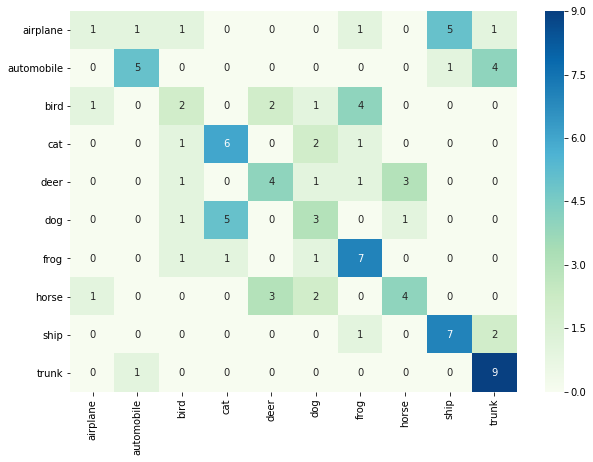

In [22]:
# ヒートマップ表示
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

df_cmx = pd.DataFrame(cmx, index=labels, columns=labels)
plt.figure(figsize = (10,7))
sn.heatmap(df_cmx, cmap=cm.GnBu, annot=True)
plt.show()

In [ ]:
# エラーリストの作成
error_list = [(files[i], answers[i], preds[i], scores[i]) 
    for i in range(len(files)) if answers[i] != preds[i]]   

In [ ]:
# 分類エラーになったイメージの表示
for item in error_list:
    print(item[0], item[1], item[2], item[3])
    display_img(item[0])

#### (参考)分析結果をexportしたい場合

In [ ]:
# 計算結果をDataFrameに変換
import pandas as pd
data = pd.DataFrame(results)
data.head()

In [ ]:
# DataFrameをCSVエクスポート
data.to_csv('cifar10-test-200.csv')


In [ ]:
# csvファイルをCOS(Cloud Object Storage)にexportする方法は別資料を参照して下さい